## Step 1: Imports & Setup

In [5]:
# Required Libraries
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import os

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Step 2: Define your dataset class

In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from PIL import Image

class AQIDataset(Dataset):
    def __init__(self, images_dir, labels_csv, transform=None):
        self.images_dir = images_dir
        self.labels = pd.read_csv(labels_csv)
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labels.iloc[idx]
        img_name = row['Filename']
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Retrieve the pollutant labels
        labels = row[['VOC', 'CO', 'NO2', 'SO2', 'PM25', 'PM10', 'O3']].values.astype('float32')
        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels   # Return the image, pollutant labels, and tabular data


## Step 3: Prepare datasets and dataloaders

In [3]:
# Data Transforms
data_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

# Read labels.csv
labels_df = pd.read_csv('all_timeslot_cleaned.csv')

# Split into train and validation sets
train_df, val_df = train_test_split(labels_df, test_size=0.1, random_state=42, shuffle=True)

# Save temporary csv for convenience
train_df.to_csv('train_labels.csv', index=False)
val_df.to_csv('val_labels.csv', index=False)

# Prepare Dataset objects
train_dataset = AQIDataset('all_images/', 'train_labels.csv', transform=data_transforms)
print(f'Len of training: {len(train_dataset)}')
val_dataset = AQIDataset('all_images/', 'val_labels.csv', transform=data_transforms)
print(f'Len of validation: {len(val_dataset)}')
# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


Len of training: 18550
Len of validation: 2062


## Step 4: Define your Model

In [6]:

# pip install torch torchvision
import torch
import torch.nn as nn
from torchvision.models import vit_b_16, vit_l_16, ViT_B_16_Weights, ViT_L_16_Weights

# pip install torch torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import (
    # ResNet
    resnet18, resnet50, ResNet18_Weights, ResNet50_Weights,
    # ConvNeXt
    convnext_tiny, ConvNeXt_Tiny_Weights,
    # ViT
    vit_b_16, vit_l_16, ViT_B_16_Weights, ViT_L_16_Weights,
    # Swin
    swin_t, swin_b, Swin_T_Weights, Swin_B_Weights
)

_BACKBONES = {
    # ResNet
    "resnet18":  ("resnet", resnet18, ResNet18_Weights),
    "resnet50":  ("resnet", resnet50, ResNet50_Weights),
    # ConvNeXt
    "convnext_tiny": ("convnext", convnext_tiny, ConvNeXt_Tiny_Weights),
    # ViT
    "vit_b_16":  ("vit",  vit_b_16, ViT_B_16_Weights),
    "vit_l_16":  ("vit",  vit_l_16, ViT_L_16_Weights),
    # Swin
    "swin_t":    ("swin", swin_t, Swin_T_Weights),
    "swin_b":    ("swin", swin_b, Swin_B_Weights),
}

def _make_encoder(name: str, pretrained: bool = True):
    """
    Builds a backbone that returns a vector feature for an input image.
    Returns: (encoder_module, feature_dim)
    """
    if name not in _BACKBONES:
        raise ValueError(f"Unknown backbone '{name}'. "
                         f"Choose from: {list(_BACKBONES.keys())}")

    family, ctor, weights_enum = _BACKBONES[name]
    weights = weights_enum.DEFAULT if pretrained else None
    m = ctor(weights=weights)

    if family == "resnet":
        # Replace fc with Identity; the model forward then returns pooled features
        feat_dim = m.fc.in_features
        m.fc = nn.Identity()
        encoder = m                                   # (N, feat_dim)
    elif family == "convnext":
        # Use features + GAP ourselves (avoid the classifier which expects LayerNorm2d)
        # ConvNeXt-Tiny has C=768 before classifier
        feat_dim = 768
        encoder = nn.Sequential(
            m.features,                               # (N, 768, H, W)
            nn.AdaptiveAvgPool2d(1),                  # (N, 768, 1, 1)
            nn.Flatten(1)                             # (N, 768)
        )
    elif family == "vit":
        # Replace classifier heads; forward returns CLS embedding (N, embed_dim)
        feat_dim = m.heads.head.in_features
        m.heads = nn.Identity()
        encoder = m                                   # (N, feat_dim)
    elif family == "swin":
        # Replace head; forward returns pooled/normalized feature (N, embed_dim)
        feat_dim = m.head.in_features
        m.head = nn.Identity()
        encoder = m                                   # (N, feat_dim)
    else:
        raise RuntimeError("Unhandled backbone family.")

    return encoder, feat_dim

class AQINet(nn.Module):
    """
    Single-image regression with a selectable backbone:
      - ResNet:        'resnet18', 'resnet50'
      - ConvNeXt:      'convnext_tiny'
      - Vision Transformer: 'vit_b_16', 'vit_l_16'
      - Swin Transformer:   'swin_t', 'swin_b'
    The model uses a backbone feature vector and a small MLP head.
    """
    def __init__(self,
                 output_dim: int = 7,
                 backbone: str = "vit_b_16",
                 pretrained: bool = True,
                 head_hidden: int = 256,
                 dropout: float = 0.2):
        super().__init__()
        self.backbone_name = backbone
        self.encoder, feat_dim = _make_encoder(backbone, pretrained)

        self.head = nn.Sequential(
            nn.LayerNorm(feat_dim),
            nn.Linear(feat_dim, head_hidden),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(head_hidden, output_dim)  # regression: no activation
        )

    def forward(self, img):
        feats = self.encoder(img)           # (N, feat_dim)
        # Some encoders may output (N, C, 1, 1) if you swap implementations;
        # flatten defensively (safe no-op if already (N, C)).
        if feats.dim() == 4:
            feats = feats.squeeze(-1).squeeze(-1)
        return self.head(feats)

# -----------------------------



In [7]:
# Examples
# -----------------------------
# ViT base 16x16
# model = AQINet(backbone="vit_b_16").to(device)

# Swin-T
# model = AQINet(backbone="swin_t").to(device)

# ResNet-50
# model = AQINet(backbone="resnet18").to(device)

# ConvNeXt-Tiny
model = AQINet(backbone="convnext_tiny").to(device)


In [6]:
from torchinfo import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable}/{total}")
summary(model.to(device))

Device: cuda
Trainable params: 28018791/28018791


Layer (type:depth-idx)                             Param #
AQINet                                             --
├─Sequential: 1-1                                  --
│    └─Sequential: 2-1                             --
│    │    └─Conv2dNormActivation: 3-1              4,896
│    │    └─Sequential: 3-2                        237,888
│    │    └─Sequential: 3-3                        74,112
│    │    └─Sequential: 3-4                        918,144
│    │    └─Sequential: 3-5                        295,680
│    │    └─Sequential: 3-6                        10,817,280
│    │    └─Sequential: 3-7                        1,181,184
│    │    └─Sequential: 3-8                        14,289,408
│    └─AdaptiveAvgPool2d: 2-2                      --
│    └─Flatten: 2-3                                --
├─Sequential: 1-2                                  --
│    └─LayerNorm: 2-4                              1,536
│    └─Linear: 2-5                                 196,864
│    └─GELU: 2-6        

## Step 5: Define Loss and Optimizer

In [7]:
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)


## Step 6: Training Loop

In [8]:
import numpy as np
import torch
from tqdm.auto import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

num_epochs = 50
best_model_path = "best_single_image_model.pth"
# Initialize tracking variables
best_val_r2 = -np.inf
columns = ['VOC', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10', 'O3']
num_pollutants = len(columns)

# History dictionary to track metrics
history = {
    'train_loss': [],
    'val_loss': [],
    'mae': [],
    'rmse': [],
    'r2': [],
    'per_pollutant_r2': [[] for _ in range(num_pollutants)]
}

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    # ------------------------ Training ------------------------
    model.train()
    train_loss = 0.0
    
    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        train_loss += loss.item() * images.size(0)
    
    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    history['train_loss'].append(train_loss)

    # ------------------------ Validation ------------------------
    model.eval()
    val_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():  # Disable gradient computation
        for images, labels in val_loader:
            # Move data to device
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Accumulate loss and predictions
            val_loss += loss.item() * images.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    history['val_loss'].append(val_loss)

    # Convert to NumPy arrays for metric calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate regression metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Store metrics
    history['mae'].append(mae)
    history['rmse'].append(rmse)
    history['r2'].append(r2)

    # Print epoch summary
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")

    # Per-pollutant R² scores
    print("Per-pollutant R² Scores:")
    for i, name in enumerate(columns):
        pollutant_r2 = r2_score(y_true[:, i], y_pred[:, i])
        history['per_pollutant_r2'][i].append(pollutant_r2)
        print(f"  {name}: {pollutant_r2:.4f}")

    # Model checkpointing - save if current model is better
    if r2 > best_val_r2:
        best_val_r2 = r2
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_r2': best_val_r2,
            'loss': criterion
        }, best_model_path)
        print(f"✅ Saved best model (R²: {best_val_r2:.4f})")

print('\n***Training Complete***')
print(f"Best Validation R²: {best_val_r2:.4f}")


Training Progress:   0%|          | 0/50 [00:00<?, ?it/s]


Epoch [1/50]
Train Loss: 965.4988 | Val Loss: 306.6882
MAE: 8.1682 | RMSE: 17.5125 | R²: -0.2180
Per-pollutant R² Scores:
  VOC: -1.2664
  CO: -0.1394
  NO2: -0.0016
  SO2: -0.0573
  PM2.5: -0.0304
  PM10: -0.0288
  O3: -0.0022
✅ Saved best model (R²: -0.2180)

Epoch [2/50]
Train Loss: 148.1595 | Val Loss: 40.2124
MAE: 3.2929 | RMSE: 6.3413 | R²: 0.2681
Per-pollutant R² Scores:
  VOC: -0.1986
  CO: 0.3582
  NO2: 0.3372
  SO2: -0.1627
  PM2.5: 0.3196
  PM10: 0.2952
  O3: 0.9278
✅ Saved best model (R²: 0.2681)

Epoch [3/50]
Train Loss: 41.3519 | Val Loss: 19.8379
MAE: 2.5826 | RMSE: 4.4540 | R²: 0.3279
Per-pollutant R² Scores:
  VOC: -0.4663
  CO: 0.5297
  NO2: 0.7420
  SO2: -0.1093
  PM2.5: 0.3063
  PM10: 0.3248
  O3: 0.9680
✅ Saved best model (R²: 0.3279)

Epoch [4/50]
Train Loss: 26.8566 | Val Loss: 12.2820
MAE: 1.9979 | RMSE: 3.5046 | R²: 0.5072
Per-pollutant R² Scores:
  VOC: 0.1937
  CO: 0.5782
  NO2: 0.8461
  SO2: -0.2225
  PM2.5: 0.5754
  PM10: 0.5998
  O3: 0.9795
✅ Saved best m

## Visualization

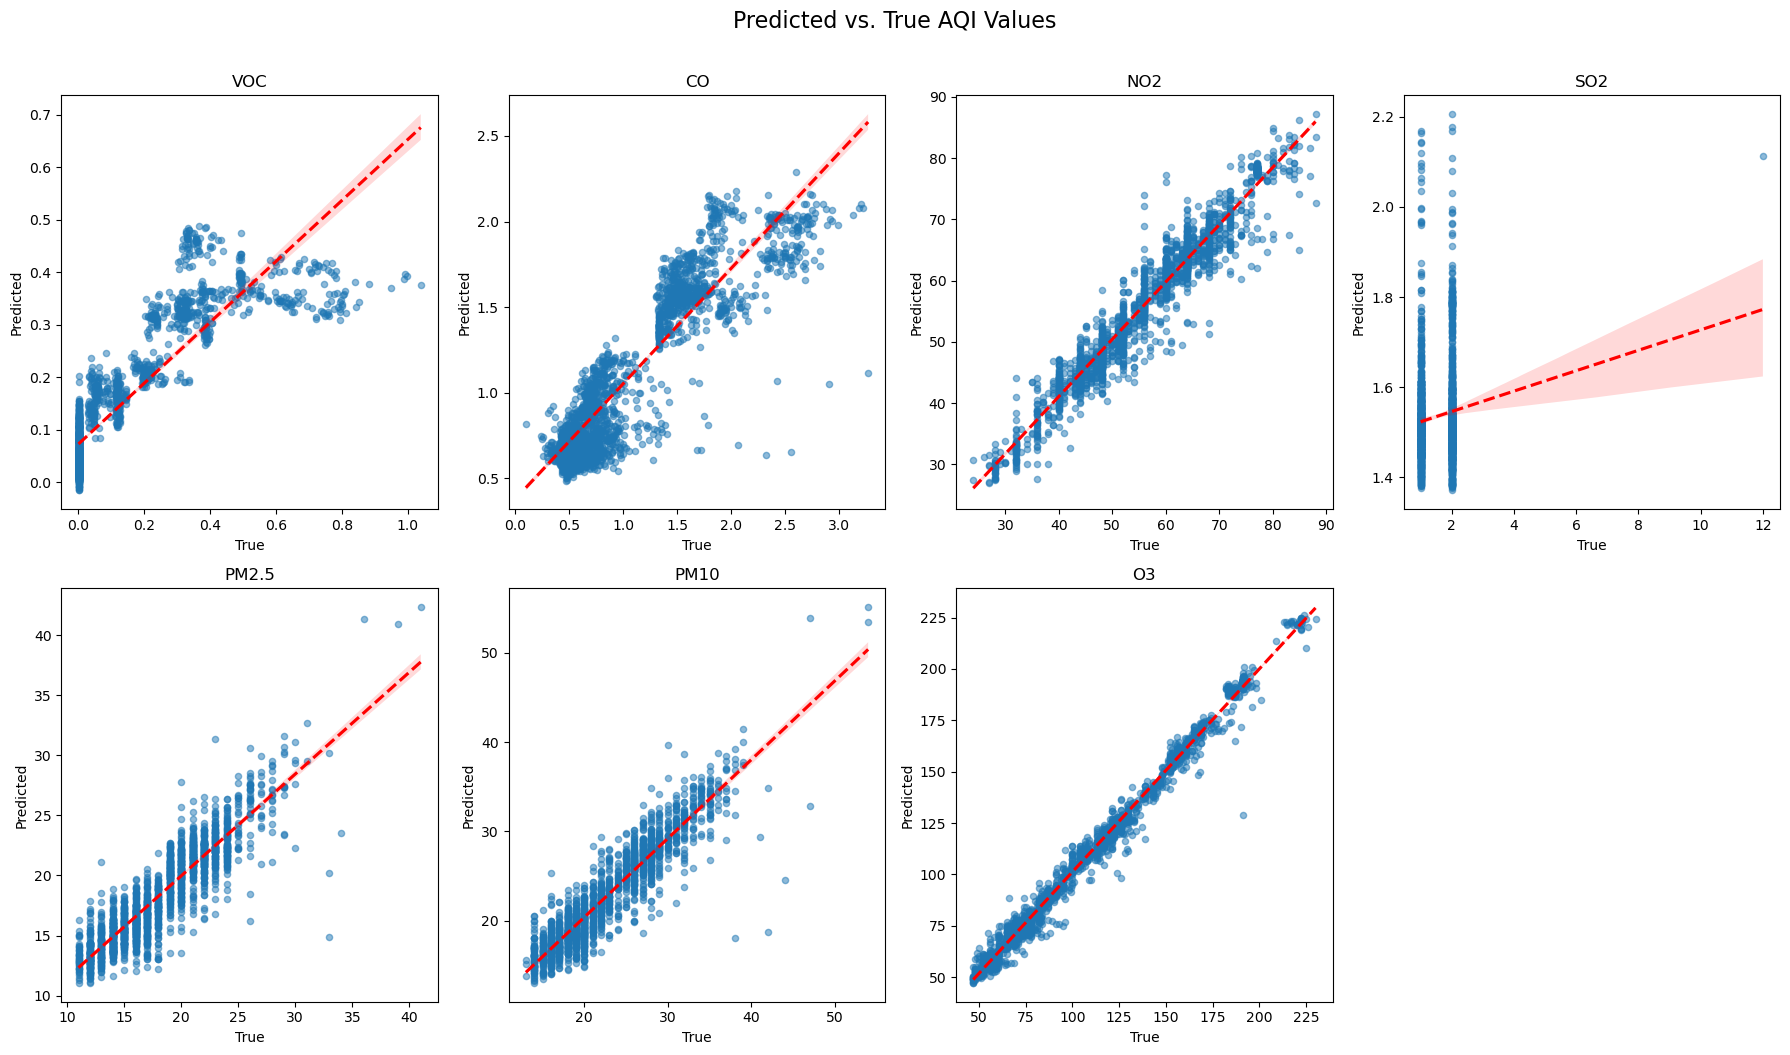

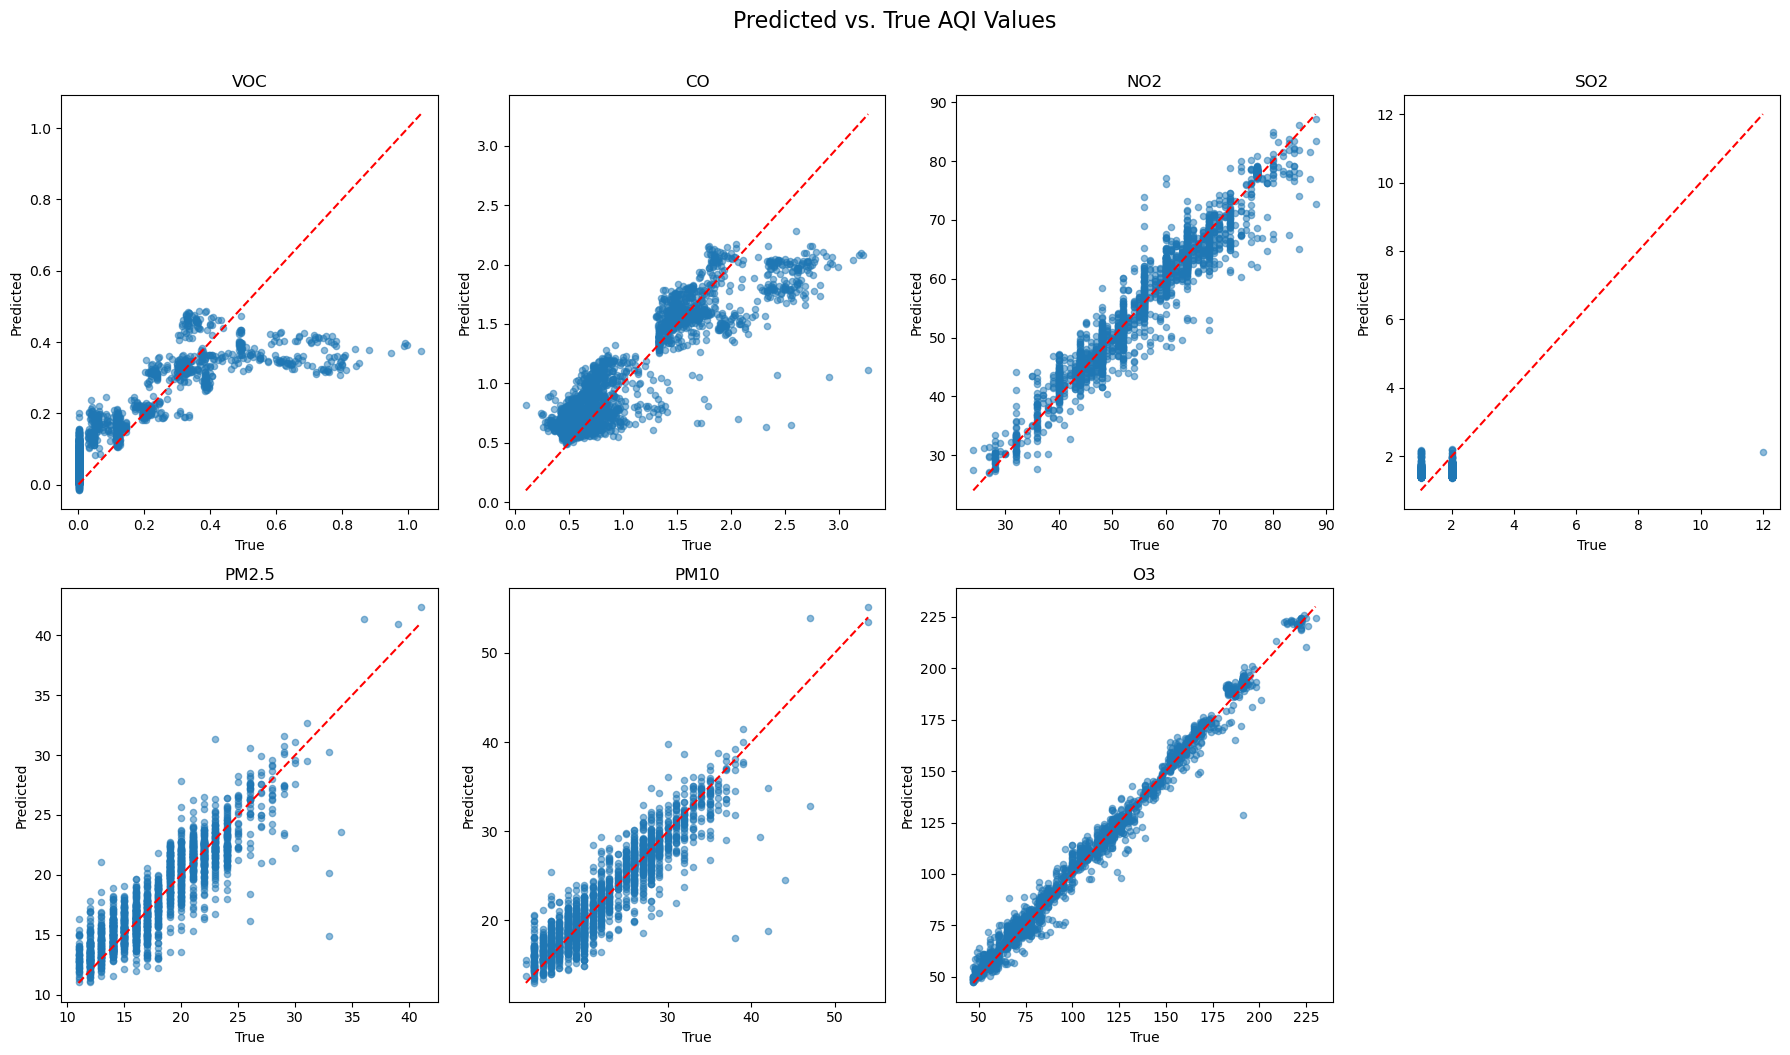

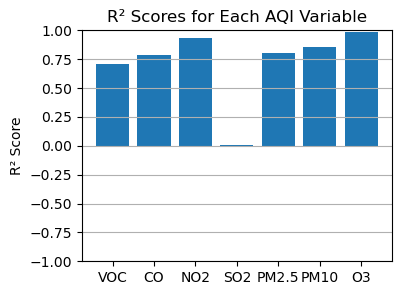

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

pollutants = ['VOC', 'CO', 'NO2', 'SO2', 'PM2.5', 'PM10', 'O3']
n_vars = len(pollutants)

plt.figure(figsize=(18, 10))
for i in range(n_vars):
    plt.subplot(2, 4, i+1)
    # Use regplot for scatter and regression line
    sns.regplot(x=y_true[:, i], y=y_pred[:, i], scatter_kws={'alpha': 0.5, 's': 20}, line_kws={'color': 'red', 'linestyle': '--'})
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(pollutants[i])
plt.tight_layout()
plt.suptitle("Predicted vs. True AQI Values", fontsize=16, y=1.05)
plt.show()

plt.figure(figsize=(18, 10))
for i in range(n_vars):
    plt.subplot(2, 4, i+1)
    plt.scatter(y_true[:, i], y_pred[:, i], alpha=0.5, s=20)
    plt.plot([y_true[:, i].min(), y_true[:, i].max()],
    [y_true[:, i].min(), y_true[:, i].max()], 'r--')
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(pollutants[i])
plt.tight_layout()
plt.suptitle("Predicted vs. True AQI Values", fontsize=16, y=1.05)
plt.show()

from sklearn.metrics import r2_score
r2_scores = [r2_score(y_true[:, i], y_pred[:, i]) for i in range(n_vars)]
plt.figure(figsize=(4, 3))
plt.bar(pollutants, r2_scores)
plt.ylabel("R² Score")
plt.title("R² Scores for Each AQI Variable")
plt.ylim(-1, 1)
plt.grid(axis='y')
plt.show()



## Step 7: Save your trained model

In [10]:
torch.save(model.state_dict(), 'aqi_model.pth')
print('Model saved successfully.')


Model saved successfully.


## Step 8: Prediction function & Demo

In [10]:
import os
from pathlib import Path
import pandas as pd
from PIL import Image
import torch
from torchvision import transforms
from tqdm.auto import tqdm

# -------- settings --------
input_path = Path("YauTsingMong/")   # single image OR folder
output_csv = "Yau Tsing Mong Air Esitimate.csv"
valid_exts = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}

# ensure model ready
# ConvNeXt-Tiny
model = AQINet(backbone="convnext_tiny").to(device)
# model.to(device)
# Load trained weights (safe, no UnpicklingError because we saved only state_dict)
state = torch.load("best_single_image_model.pth", map_location=device)
model.load_state_dict(state, strict=False)  # only if strict=True fails
model.eval()

# same transform as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

def predict_aqi(image_path, model, device):
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor).cpu().numpy()[0]

    return {
        "VOC": output[0],
        "CO": output[1],
        "NO2": output[2],
        "SO2": output[3],
        "PM2.5": output[4],
        "PM10": output[5],
        "O3": output[6],
    }

def _list_images(folder: Path):
    return sorted(
        [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() in valid_exts],
        key=lambda p: p.name
    )

# -------- run --------
if input_path.is_file():
    pred = predict_aqi(str(input_path), model, device)
    print(f"\nPredicted AQI values for {input_path.name}:")
    for k, v in pred.items():
        print(f"  {k}: {v:.3f}")

elif input_path.is_dir():
    images = _list_images(input_path)
    if not images:
        raise ValueError(f"No valid images found in {input_path}")

    rows = []
    for img_path in tqdm(images, desc="Inferring"):
        pred = predict_aqi(str(img_path), model, device)
        print(f"\n{img_path.name}:")
        for k, v in pred.items():
            print(f"  {k}: {v:.3f}")
        row = {"Filename": img_path.name}
        row.update(pred)
        rows.append(row)

    df = pd.DataFrame(rows, columns=["Filename", "VOC", "CO", "NO2", "SO2", "PM2.5", "PM10", "O3"])
    df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"\nSaved predictions to: {output_csv}")


else:
    raise FileNotFoundError(f"Path not found: {input_path}")


C:\Users\User\AppData\Local\Temp\ipykernel_24160\4044513575.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load("best_single_image_model.pth", map_locati

Inferring:   0%|          | 0/15313 [00:00<?, ?it/s]


0_114.155583_22.32122_1708.jpg:
  VOC: 0.048
  CO: 0.178
  NO2: -0.128
  SO2: -0.500
  PM2.5: 0.186
  PM10: 0.209
  O3: 0.122

10000_114.162297_22.322854_1707.jpg:
  VOC: -0.018
  CO: 0.187
  NO2: -0.074
  SO2: -0.330
  PM2.5: 0.129
  PM10: 0.142
  O3: -0.111

10001_114.162389_22.322789_1707.jpg:
  VOC: -0.017
  CO: 0.140
  NO2: -0.072
  SO2: -0.349
  PM2.5: 0.116
  PM10: 0.195
  O3: -0.143

10002_114.16245_22.322744_1707.jpg:
  VOC: 0.012
  CO: 0.139
  NO2: -0.085
  SO2: -0.431
  PM2.5: 0.128
  PM10: 0.234
  O3: -0.126

10003_114.162547_22.322672_1707.jpg:
  VOC: 0.013
  CO: 0.179
  NO2: -0.058
  SO2: -0.467
  PM2.5: 0.097
  PM10: 0.210
  O3: -0.116

10004_114.162618_22.322616_1707.jpg:
  VOC: -0.002
  CO: 0.159
  NO2: -0.122
  SO2: -0.448
  PM2.5: 0.143
  PM10: 0.187
  O3: 0.004

10005_114.170731_22.303207_1403.jpg:
  VOC: -0.136
  CO: 0.236
  NO2: -0.257
  SO2: -0.155
  PM2.5: 0.105
  PM10: 0.036
  O3: 0.070

10006_114.174095_22.307108_1707.jpg:
  VOC: 0.129
  CO: 0.059
  NO2: -0.2

KeyboardInterrupt: 